# Statistical tests

Here we will conduct few ANOVA tests to see firstly which scaffolds are most effective on ERa and secondly, which scaffolds have the most diverse effect on different receptors.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

from rdkit import Chem
# from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, MolToInchi, InchiToInchiKey, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

from tqdm import tqdm_notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
df_clean = pd.read_csv('secondary_data/df_clean.csv', index_col=0)
df_molecules_std = pd.read_csv('secondary_data/df_molecules_std.csv', index_col=0)
df_activity = pd.read_csv('secondary_data/df_activity.csv', index_col=0)

df_scaffolds = pd.read_csv('secondary_data/df_scaffolds.csv', index_col=0)
df_scaffolds.scaffold_smiles.fillna('', inplace=True)
PandasTools.AddMoleculeColumnToFrame(df_scaffolds,smilesCol='scaffold_smiles', molCol='mol')

In [3]:
df_join = df_activity.join(df_molecules_std, on='std_inchi_key')
df_join.rename(lambda x:x.replace('pChEMBL_Value', 'activity'), axis='columns', inplace=True)

In [4]:
df_era = df_join.query('receptor_name == "ERa"').copy()

## ANOVA on ERa

Again we pick ERa receptor and now we try to see which scaffolds show the best activity.

One way is to use scipy and provide activities for each scaffold (the usual ANOVA)

In [45]:
f_statistic, p_value = f_oneway(*[df_era.query('scaffold_inchi_key == "%s"' % sic)['activity'].values for sic in set(df_era.dropna().scaffold_inchi_key.values)])
print('F = %.3f, p = %.2e' % (f_statistic, p_value))

F = 7.615, p = 3.04e-244


The other way is to use statsmodels, fit a linear model where the scaffolds will be dummy-encoded (one-hot-encoded) and perform ANOVA on the linear model.

In [46]:
mod = ols('activity ~ scaffold_inchi_key', data=df_era).fit()
sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
scaffold_inchi_key,693.0,3533.328660,5.098598,7.615144,3.039911e-244
Residual,1602.0,1072.593549,0.669534,NaN,NaN


We see it gives us the same results, because it essentialy does the same thing (https://www.theanalysisfactor.com/why-anova-and-linear-regression-are-the-same-analysis/)

However from the linear model we also get the individual t-tests for each coefficient (scaffold).

In [82]:
df_t2 = mod.summary2().tables[1]
df_t2.head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.130000,0.818251,6.269473,4.648042e-10,3.525046,6.734954
scaffold_inchi_key[T.ABLKGTGPWMEPMN-UHFFFAOYSA-N],-0.200000,1.157181,-0.172834,8.628039e-01,-2.469748,2.069748
scaffold_inchi_key[T.ABPFTEHYNPDNKD-UHFFFAOYSA-N],0.135000,1.002148,0.134711,8.928576e-01,-1.830660,2.100660
scaffold_inchi_key[T.ACMIWZBDYJRVBC-UHFFFAOYSA-N],1.999545,0.854635,2.339649,1.942415e-02,0.323225,3.675866
scaffold_inchi_key[T.ACRZFSAANSPSPB-UHFFFAOYSA-N],-0.230000,1.157181,-0.198759,8.424766e-01,-2.499748,2.039748


In [83]:
df_t2.reset_index(inplace=True)
df_t2['scaffold_inchi_key'] = df_t2['index'].apply(lambda x:x.replace('scaffold_inchi_key[T.','')[:-1])  # reconstruct the inchi keys back from the index column

We also calculate number of molecules associated with each scaffold

In [84]:
df_scaffolds_count = df_join \
    .reset_index() \
    .groupby('scaffold_inchi_key') \
    .count()['std_inchi_key'] \
    .to_frame() \
    .rename(lambda x:x.replace('std_inchi_key','mol_count'), axis='columns') \
    .join(df_scaffolds.set_index('scaffold_inchi_key'), on='scaffold_inchi_key') \
    .drop(['scaffold_smiles', 'scaffold_morgan_fp'], axis='columns') \
    .copy()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],scaffold_inchi_key,mol_count,mol,cluster_label
0,5.130000,0.818251,6.269473,4.648042e-10,3.525046,6.734954,Intercep,NaN,NaN,NaN
154,4.206000,0.845086,4.977011,7.153164e-07,2.548410,5.863590,GMTFFCIWNVECDO-UHFFFAOYSA-N,30.0,,cluster_139
202,4.330000,0.914832,4.733110,2.405836e-06,2.535607,6.124393,IDPHKQAXIZGCQK-UHFFFAOYSA-N,8.0,,cluster_23
249,3.809239,0.827097,4.605554,4.438790e-06,2.186933,5.431545,JVFAUCWIQIEJCK-UHFFFAOYSA-N,98.0,,cluster_136
14,3.685185,0.833266,4.422582,1.040969e-05,2.050780,5.319591,ANUPXDQDVSQCDG-UHFFFAOYSA-N,27.0,,cluster_20
106,3.896667,0.883812,4.408933,1.107928e-05,2.163118,5.630215,DPEGHWQCBAQVRT-UHFFFAOYSA-N,6.0,,cluster_163
280,4.103333,0.944834,4.342913,1.494239e-05,2.250092,5.956575,KVQUDZGZJINXRL-UHFFFAOYSA-N,6.0,,cluster_23
246,3.808333,0.883812,4.308987,1.739782e-05,2.074785,5.541882,JSVILEFZXZLOES-UHFFFAOYSA-N,11.0,,cluster_106
398,3.655417,0.851662,4.292097,1.875944e-05,1.984927,5.325906,PEJLABVRMPYBNL-UHFFFAOYSA-N,24.0,,cluster_23
152,3.903333,0.944834,4.131235,3.794436e-05,2.050092,5.756575,GLJXOMHTIBKMIS-UHFFFAOYSA-N,5.0,,cluster_139

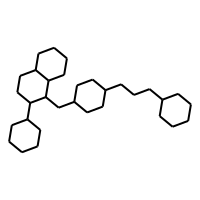
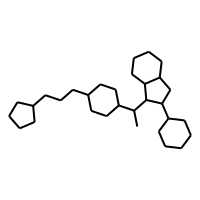
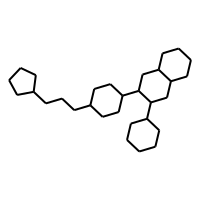
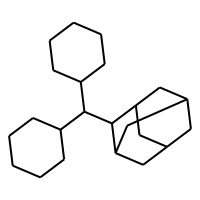
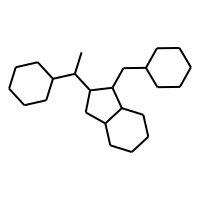
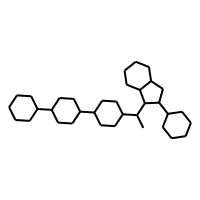
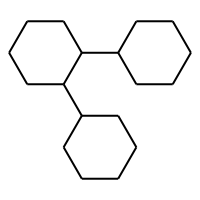
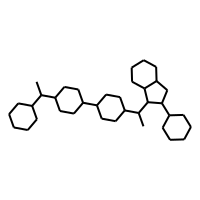
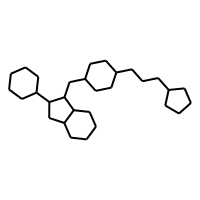

In [85]:
df_t2.join(df_scaffolds_count, on='scaffold_inchi_key').drop('index', axis='columns').sort_values('P>|t|', ascending=True).head(10)

## ANOVA on clusters

Now we try the same ANOVA test but using clusters instead of scaffolds.

In [86]:
df_era_scaffolds = df_era.join(df_scaffolds.set_index('scaffold_smiles'), on='scaffold_smiles', lsuffix='_l')
mod = ols('activity ~ cluster_label', data=df_era_scaffolds).fit()
sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
cluster_label,146.0,2595.782230,17.77933,19.020215,3.606175e-290
Residual,2148.0,2007.863844,0.93476,NaN,NaN


And we get even lower p-value. We again list first few significant clusters.

In [91]:
mod.summary2().tables[1].sort_values('P>|t|', ascending=True).head(10)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,7.465000,0.558199,13.373357,3.067980e-39,6.370332,8.559668
cluster_label[T.cluster_38],-2.953333,0.683652,-4.319938,1.631828e-05,-4.294022,-1.612645
cluster_label[T.cluster_80],-2.779444,0.644553,-4.312204,1.689471e-05,-4.043458,-1.515431
cluster_label[T.cluster_35],-2.637143,0.615106,-4.287300,1.888575e-05,-3.843408,-1.430878
cluster_label[T.cluster_140],-2.713000,0.636445,-4.262739,2.106710e-05,-3.961113,-1.464887
cluster_label[T.cluster_71],-2.708000,0.636445,-4.254883,2.181410e-05,-3.956113,-1.459887
cluster_label[T.cluster_53],-2.631154,0.619267,-4.248822,2.240756e-05,-3.845578,-1.416729
cluster_label[T.cluster_184],-2.799286,0.667176,-4.195724,2.830668e-05,-4.107664,-1.490908
cluster_label[T.cluster_24],-2.745000,0.667176,-4.114357,4.029039e-05,-4.053378,-1.436622
cluster_label[T.cluster_54],-2.810000,0.683652,-4.110279,4.100294e-05,-4.150688,-1.469312


# ANOVA: scaffolds that produce different effect on different receptors

We know that many molecules are promisculous, meaning they are active on many receptors. Here we want to find scaffolds that produce significantly different effect on the receptors.

We filter those scaffolds that have data for all six receptors. With those we perform ANOVA test.

In [23]:
df_scaffolds_count = df_join \
    .reset_index() \
    .groupby('scaffold_inchi_key') \
    .count()['std_inchi_key'] \
    .to_frame() \
    .rename(lambda x:x.replace('std_inchi_key','mol_count'), axis='columns') \
    .join(df_scaffolds.set_index('scaffold_inchi_key'), on='scaffold_inchi_key') \
    .copy()

In [24]:
results = []
for scaffold_inchi_key,scaffold_row in df_scaffolds_count.sort_values('mol_count', ascending=False).iterrows():
    df = df_join.query('scaffold_inchi_key == "{}"'.format(scaffold_inchi_key))
    if len(set(df['receptor_name'])) == 6:
        mod = ols('activity ~ receptor_name', data=df).fit()
        p_F_statistic = sm.stats.anova_lm(mod, typ=1)['PR(>F)']['receptor_name']
        if p_F_statistic > 0.05:
            continue
        results.append({'scaffold_inchi_key':scaffold_inchi_key, 'mol':scaffold_row['mol'], 'p_F':p_F_statistic, 'n_mols':scaffold_row['mol_count'], 'table':mod.summary2().tables[1]})
df_results = pd.DataFrame(results).set_index('scaffold_inchi_key').dropna(subset=['p_F']).sort_values('p_F')

f:\programy\Miniconda3\envs\main\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
f:\programy\Miniconda3\envs\main\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
f:\programy\Miniconda3\envs\main\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))
f:\programy\Miniconda3\envs\main\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))
f:\programy\Miniconda3\envs\main\lib\site-packages\statsmodels\stats\anova.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  (model.ssr / model.df_resid))
f:\programy\Miniconda3\envs\main\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarn

We show the tables from linear models. The Coef. of Intercept is interpreted as a baseline activity of the scaffold. The rows for each receptor tell us whether there is a significant (p-value of t-test) increase or decrease of activity on that receptor compared to the baseline.

Scaffold RARGZVQPBDQEDG-UHFFFAOYSA-N


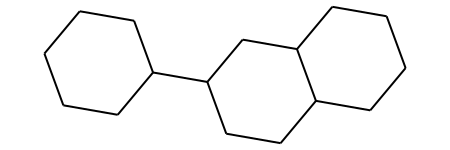

p(F): 2.44e-15
# mols: 272


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.765000,0.526065,10.958717,2.620105e-23,4.729218,6.800782
receptor_name[T.ERa],0.698178,0.533389,1.308946,1.916822e-01,-0.352024,1.748379
receptor_name[T.ERb],1.786182,0.533191,3.349987,9.252058e-04,0.736371,2.835993
receptor_name[T.GR],0.728125,0.573266,1.270134,2.051468e-01,-0.400592,1.856842
receptor_name[T.MR],0.220000,1.052130,0.209100,8.345306e-01,-1.851563,2.291563
receptor_name[T.PR],1.016857,0.548147,1.855080,6.469119e-02,-0.062403,2.096117



---

Scaffold QBGUDIWPZRUHPZ-UHFFFAOYSA-N


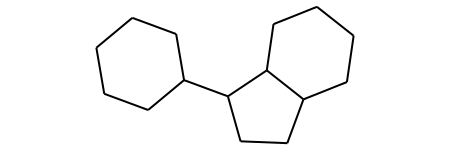

p(F): 2.56e-11
# mols: 141


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,6.232045,0.175492,35.511925,2.362898e-70,5.884977,6.579114
receptor_name[T.ERa],0.425955,0.218485,1.949580,5.329916e-02,-0.006142,0.858051
receptor_name[T.ERb],1.388339,0.238446,5.822443,4.029345e-08,0.916766,1.859912
receptor_name[T.GR],0.648409,0.248183,2.612629,1.000304e-02,0.157580,1.139238
receptor_name[T.MR],0.157955,0.275621,0.573087,5.675392e-01,-0.387138,0.703047
receptor_name[T.PR],1.770455,0.270451,6.546310,1.131705e-09,1.235586,2.305323



---

Scaffold KEDGTCQHVZVXLG-UHFFFAOYSA-N


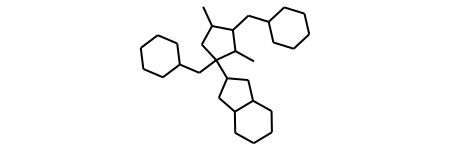

p(F): 5.88e-08
# mols: 32


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.220000e+00,0.202560,2.577014e+01,4.861917e-20,4.803632,5.636368
receptor_name[T.ERa],3.666667e-02,0.309416,1.185030e-01,9.065799e-01,-0.599346,0.672679
receptor_name[T.ERb],9.250000e-02,0.286463,3.229037e-01,7.493507e-01,-0.496333,0.681333
receptor_name[T.GR],-2.220446e-15,0.309416,-7.176260e-15,1.000000e+00,-0.636013,0.636013
receptor_name[T.MR],1.467857e+00,0.229681,6.390839e+00,9.052898e-07,0.995740,1.939974
receptor_name[T.PR],1.600000e-01,0.286463,5.585362e-01,5.812571e-01,-0.428833,0.748833



---

Scaffold NPKNVHSPURAGKC-UHFFFAOYSA-N


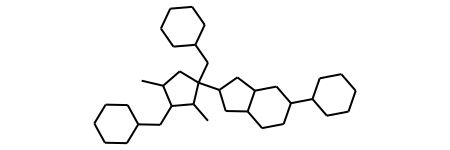

p(F): 1.53e-07
# mols: 16


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.270000,0.140647,37.469610,4.366975e-12,4.956618,5.583382
receptor_name[T.ERa],-0.115000,0.198905,-0.578164,5.759408e-01,-0.558189,0.328189
receptor_name[T.ERb],0.155000,0.198905,0.779265,4.538701e-01,-0.288189,0.598189
receptor_name[T.GR],0.140000,0.198905,0.703852,4.975864e-01,-0.303189,0.583189
receptor_name[T.MR],2.053333,0.162406,12.643248,1.785201e-07,1.691471,2.415195
receptor_name[T.PR],0.360000,0.198905,1.809906,1.004177e-01,-0.083189,0.803189



---

Scaffold SOZQMGCHCBDTEH-UHFFFAOYSA-N


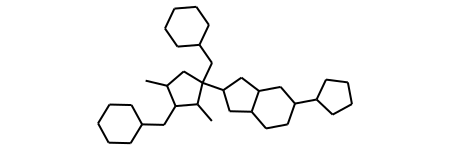

p(F): 1.57e-07
# mols: 16


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.490,0.126155,43.518010,9.861139e-13,5.208910,5.771090
receptor_name[T.ERa],-0.235,0.178410,-1.317193,2.171565e-01,-0.632521,0.162521
receptor_name[T.ERb],0.060,0.178410,0.336305,7.435915e-01,-0.337521,0.457521
receptor_name[T.GR],0.040,0.178410,0.224203,8.271137e-01,-0.357521,0.437521
receptor_name[T.MR],1.730,0.145671,11.876088,3.220765e-07,1.405425,2.054575
receptor_name[T.PR],0.055,0.178410,0.308279,7.641957e-01,-0.342521,0.452521



---

Scaffold IBLVSWYGUFGDMF-UHFFFAOYSA-N


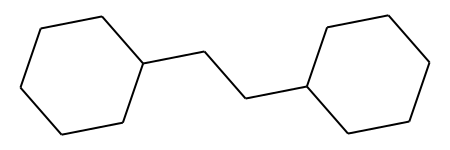

p(F): 1.49e-05
# mols: 75


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.850000,0.474607,12.325995,4.197671e-19,4.903185,6.796815
receptor_name[T.ERa],1.553056,0.512634,3.029561,3.444819e-03,0.530379,2.575732
receptor_name[T.ERb],2.393214,0.522991,4.576013,2.032801e-05,1.349875,3.436553
receptor_name[T.GR],-1.000000,1.255691,-0.796374,4.285462e-01,-3.505036,1.505036
receptor_name[T.MR],-0.790000,1.255691,-0.629135,5.313378e-01,-3.295036,1.715036
receptor_name[T.PR],0.443333,0.822043,0.539307,5.914113e-01,-1.196598,2.083264



---

Scaffold RZSCLMVIKHLBES-UHFFFAOYSA-N


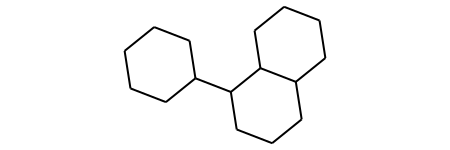

p(F): 4.26e-05
# mols: 45


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.585000,0.604776,9.234823,2.319958e-11,4.361725,6.808275
receptor_name[T.ERa],2.026607,0.626003,3.237377,2.464353e-03,0.760397,3.292817
receptor_name[T.ERb],2.400000,0.698335,3.436745,1.412691e-03,0.987484,3.812516
receptor_name[T.GR],-0.385000,0.855283,-0.450144,6.550992e-01,-2.114972,1.344972
receptor_name[T.MR],1.649000,0.715581,2.304422,2.661086e-02,0.201601,3.096399
receptor_name[T.PR],-0.260000,0.855283,-0.303993,7.627492e-01,-1.989972,1.469972



---

Scaffold IGJIKUVQYTUKGP-UHFFFAOYSA-N


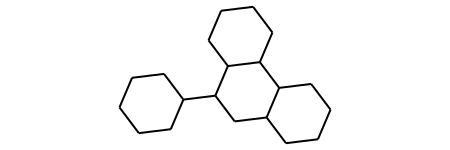

p(F): 9.15e-05
# mols: 57


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,5.120000,0.661764,7.736895,3.753538e-10,3.791453,6.448547
receptor_name[T.ERa],1.970000,0.935876,2.104980,4.023929e-02,0.091151,3.848849
receptor_name[T.ERb],4.080000,1.146209,3.559560,8.143207e-04,1.778889,6.381111
receptor_name[T.GR],2.054687,0.682131,3.012160,4.030055e-03,0.685253,3.424122
receptor_name[T.MR],0.865000,0.724926,1.193225,2.383028e-01,-0.590350,2.320350
receptor_name[T.PR],0.890000,0.724926,1.227711,2.251920e-01,-0.565350,2.345350



---

Scaffold JPUFHRNHYKFRPN-UHFFFAOYSA-N


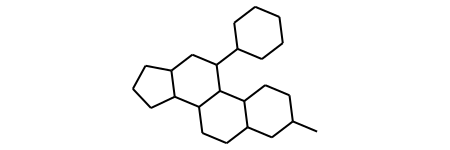

p(F): 1.80e-04
# mols: 41


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,7.747500,0.434834,17.817141,3.937346e-19,6.864740,8.630260
receptor_name[T.ERa],-1.584167,0.664220,-2.385003,2.262747e-02,-2.932605,-0.235728
receptor_name[T.ERb],-1.857500,0.753155,-2.466293,1.869511e-02,-3.386485,-0.328515
receptor_name[T.GR],0.410119,0.474443,0.864422,3.932419e-01,-0.553051,1.373289
receptor_name[T.MR],-1.752500,0.753155,-2.326879,2.588375e-02,-3.281485,-0.223515
receptor_name[T.PR],0.366944,0.522606,0.702144,4.872327e-01,-0.694001,1.427890



---

Scaffold KDWJKUYBVSGZHN-UHFFFAOYSA-N


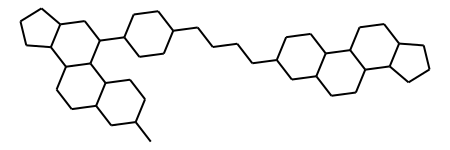

p(F): 3.36e-04
# mols: 24


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,7.863333,0.401833,19.568684,1.402932e-13,7.019115,8.707552
receptor_name[T.ERa],0.106667,0.635353,0.167886,8.685451e-01,-1.228160,1.441494
receptor_name[T.ERb],-0.600833,0.635353,-0.945669,3.568403e-01,-1.935660,0.733994
receptor_name[T.GR],1.161667,0.453328,2.562529,1.957972e-02,0.209259,2.114074
receptor_name[T.MR],-1.363333,0.568277,-2.399065,2.747956e-02,-2.557239,-0.169428
receptor_name[T.PR],1.158333,0.568277,2.038325,5.648519e-02,-0.035572,2.352239



---

Scaffold ZFKHFDRIZMTABS-UHFFFAOYSA-N


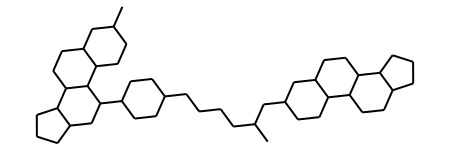

p(F): 9.26e-04
# mols: 15


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,8.046667,0.297174,27.077297,6.190775e-10,7.374413,8.718921
receptor_name[T.ERa],-0.516667,0.469873,-1.099587,3.000532e-01,-1.579594,0.546260
receptor_name[T.ERb],-0.741667,0.469873,-1.578440,1.489208e-01,-1.804594,0.321260
receptor_name[T.GR],1.453333,0.420267,3.458116,7.182127e-03,0.502622,2.404044
receptor_name[T.MR],-1.651667,0.469873,-3.515132,6.565454e-03,-2.714594,-0.588740
receptor_name[T.PR],0.916667,0.420267,2.181151,5.706736e-02,-0.034044,1.867378



---

Scaffold AWYSCAVTZFEHGB-UHFFFAOYSA-N


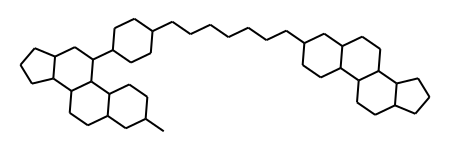

p(F): 1.00e-03
# mols: 10


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,8.400,0.145495,57.734004,5.389598e-07,7.996042,8.803958
receptor_name[T.ERa],-0.550,0.252004,-2.182501,9.448006e-02,-1.249677,0.149677
receptor_name[T.ERb],-1.110,0.252004,-4.404684,1.164866e-02,-1.809677,-0.410323
receptor_name[T.GR],1.325,0.205761,6.439517,2.991949e-03,0.753716,1.896284
receptor_name[T.MR],-1.605,0.205761,-7.800320,1.457318e-03,-2.176284,-1.033716
receptor_name[T.PR],0.645,0.205761,3.134708,3.502587e-02,0.073716,1.216284



---

Scaffold UEPGKEXXIQJJIP-UHFFFAOYSA-N


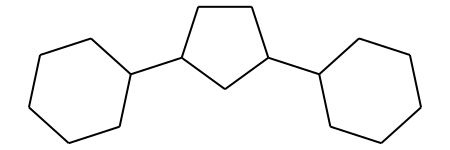

p(F): 3.73e-03
# mols: 69


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,6.243333,0.095073,65.668616,9.791942e-60,6.053344,6.433322
receptor_name[T.ERa],-0.250000,0.201681,-1.239582,2.197280e-01,-0.653027,0.153027
receptor_name[T.ERb],-0.545833,0.201681,-2.706420,8.740961e-03,-0.948861,-0.142806
receptor_name[T.GR],-1.673333,0.623437,-2.684044,9.282262e-03,-2.919174,-0.427493
receptor_name[T.MR],1.266667,0.623437,2.031746,4.640188e-02,0.020826,2.512507
receptor_name[T.PR],-0.553333,0.623437,-0.887552,3.781576e-01,-1.799174,0.692507



---

Scaffold YPLIQZFPBOSWDU-UHFFFAOYSA-N


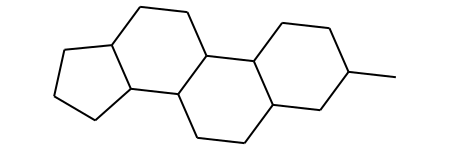

p(F): 1.13e-02
# mols: 143


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,7.148700,0.167216,42.751243,4.200378e-81,6.818041,7.479359
receptor_name[T.ERa],-1.081200,0.614392,-1.759790,8.067543e-02,-2.296117,0.133717
receptor_name[T.ERb],-0.714700,0.554593,-1.288692,1.996771e-01,-1.811370,0.381970
receptor_name[T.GR],0.499871,0.230058,2.172807,3.151471e-02,0.044948,0.954795
receptor_name[T.MR],0.433800,0.339618,1.277319,2.036502e-01,-0.237771,1.105371
receptor_name[T.PR],0.724217,0.380087,1.905395,5.882408e-02,-0.027380,1.475813



---



In [26]:
for scaffold_inchi_key,scaffold_row in df_results.iterrows():
        print('Scaffold', scaffold_inchi_key)
        display(scaffold_row['mol'])
        print('p(F): %.2e' % scaffold_row['p_F'])
        print('# mols:', scaffold_row['n_mols'])
        display(scaffold_row['table'])
        print('\n---\n')
#         break